In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pdb
import numpy as np

In [4]:
from inca.models.image import Image

In [5]:
i = Image.get(849555)
mask = i.get_maskjson_asset('ships')
mask.download_asset()
print mask.local_asset_path


pan = i.get_panchromatic_asset()
pan.download_asset()

/tmp/fa75d9df9aa44a929dff60d75ac34e68


In [6]:
mask = i.get_mask_asset

/tmp/5c9159b5a9a24c69811ef20baf91c8ab.npz


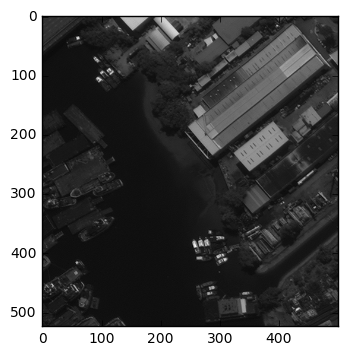

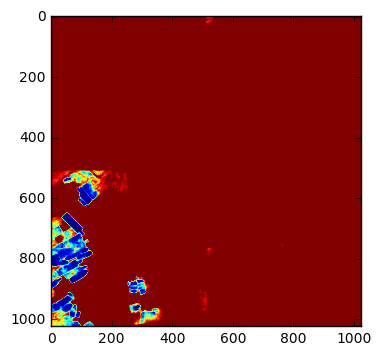

In [7]:
# Get Pan Image
pan_im = cv2.imread(pan.local_asset_path,-1)
plt.imshow(pan_im[500:,0:500],cmap=plt.get_cmap('gray'))

# Get Predicted Heatmap
plt.figure()
probs,_,hm,cm =i.get_prediction_assets(10972)
hm.download_asset()
hm_im = cv2.imread(hm.local_asset_path)
plt.imshow(hm_im,cmap=plt.get_cmap('gray'))

#Get Ground Truth Mask (cant figure out how to get it, so getting from confusion matrix)
plt.figure()
cm.download_asset()
cm_im = cv2.imread(cm.local_asset_path)

#Get Raw probs
probs.download_asset()
print probs.local_asset_path


In [8]:
import cv2

In [91]:
pan_im.shape

(1024, 1024)

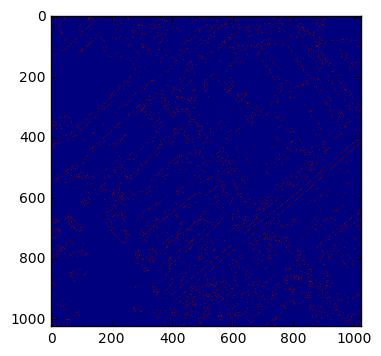

In [92]:
edges = cv2.Canny(np.uint8(pan_im),1000,1100)
plt.imshow(edges)

In [93]:
hog = cv2.HOGDescriptor()
h = hog.compute(np.uint8(pan_im))

In [94]:
h.shape

(51683940, 1)

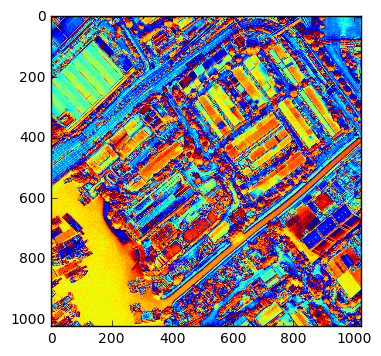

In [95]:
plt.imshow(np.uint8(pan_im))

In [96]:
edges = cv2.Canny

In [9]:
test1_im = pan_im#[500:1000,0:500]
test1_hm = hm_im#[500:1000,0:500]
test1_cm = cm_im#[500:1000,0:500]
probs_im = np.load(probs.local_asset_path)['arr_0']
test1_probs = probs_im#[500:1000,0:500]

In [10]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax, softmax_to_unary
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

In [11]:
#unary = -np.log(test1_probs + 0.0000001)

In [17]:
test1_probs.shape

(1, 1024, 1024)

In [13]:
test_back_score=1 - test1_probs

In [18]:
test_back_score.shape

(1, 1024, 1024)

In [15]:
test_back_score=np.expand_dims(test_back_score,axis=0)

In [16]:
test1_probs=np.expand_dims(test1_probs,axis=0)

In [19]:
total_unary=np.vstack((test1_probs,test_back_score))

In [20]:
total_unary.shape

(2, 1024, 1024)

In [21]:
shape_im=1024

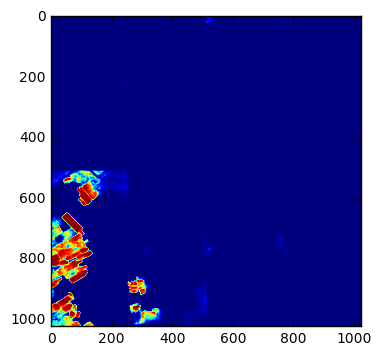

In [22]:
plt.imshow(total_unary[0].reshape((shape_im,shape_im)))

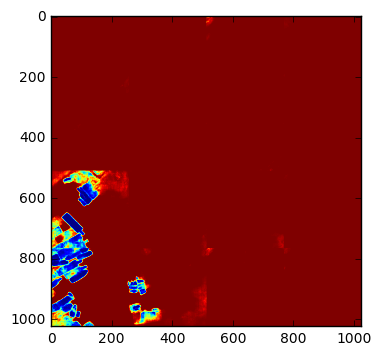

In [23]:
plt.imshow(total_unary[1].reshape((shape_im,shape_im)))

2 1024 1024
1.001 0.0010004 (2, 1048576)
0 1 int64


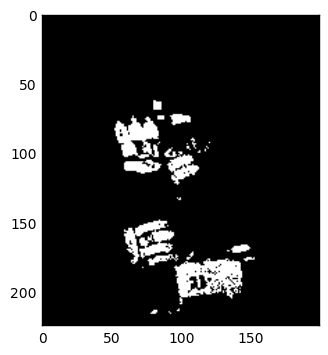

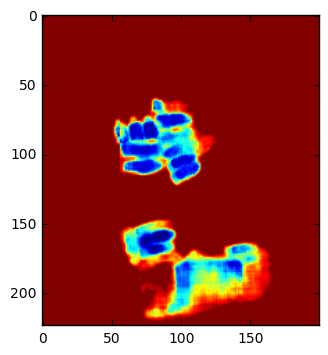

In [24]:
unary=np.copy(total_unary)
n_label = unary.shape[0]
im_height = unary.shape[1]
im_width = unary.shape[2]
print n_label,im_height,im_width
d = dcrf.DenseCRF2D(im_height, im_width, n_label)
U = unary.reshape((n_label,-1))
Up = (U+0.001) / (np.sum(U, axis=0))
print np.max(Up),np.min(Up),Up.shape
# tt=-np.log(Up+0.0000001)
# print np.max(tt),np.min(tt)
unary = softmax_to_unary(Up)
d.setUnaryEnergy(unary)
d.addPairwiseGaussian(3, 1)
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
pairwise_energy = create_pairwise_bilateral(sdims=(30,30), schan=(1,), img=test1_im.reshape((shape_im,shape_im,1)), chdim=2)
d.addPairwiseEnergy(pairwise_energy,compat=1000)

Q = d.inference(1)
Q = np.array(Q).reshape((n_label, im_height,im_width))
out_label = np.argmax(Q, axis=0)
Q.shape
out_label.shape
out_label=out_label[800:,200:400]
plt.imshow(1-out_label,cmap=plt.get_cmap('gray'))
plt.figure()
test1_hm2=test1_hm[800:,200:400]
plt.imshow(test1_hm2,cmap=plt.get_cmap('gray'))
print np.min(out_label),np.max(out_label),out_label.dtype

In [25]:
out_label.shape

(224, 200)

In [26]:
np.max(out_label)

1

In [28]:
cv2.findContours(out_label, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

TypeError: Layout of the output array image is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

In [29]:
cv2.findContours?

In [30]:
out_label.dtype

dtype('int64')

In [31]:
out_label_np=np.array(out_label,np.uint8)

In [32]:
cv2.findContours(out_label_np, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8), [array([[[  0,   0]],
  
         [[  0, 223]],
  
         [[199, 223]],
  
         [[199,   0]]], dtype=int32), array([[[ 91, 215]],
  
         [[ 92, 214]],
  
         [[ 93, 215]],
  
         [[ 92, 216]]], dtype=int32), array([[[ 90, 214]],
  
         [[ 91, 213]],
  
         [[ 92, 214]],
  
         [[ 91, 215]]], dtype=int32), array([[[ 80, 212]],
  
         [[ 82, 212]],
  
         [[ 83, 213]],
  
         [[ 83, 214]],
  
         [[ 81, 216]],
  
         [[ 78, 216]],
  
         [[ 77, 215]]], dtype=int32), array([[[ 98, 211]],
  
         [[ 99, 212]],
  
         [[ 99, 213]],
  
         [[ 98, 214]],
  
         [[ 97, 214]],
  
         [[ 96, 213]]], dtype=int32), array([[[ 98, 204]],
  
         [[ 99, 203]],
  
         [[101, 205]],

In [30]:
create_pairwise_bilateral?

In [51]:
import random

2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)


0 1 int64
2 500 500
1.001 0.0010004 (2, 250000)
0 1 int64


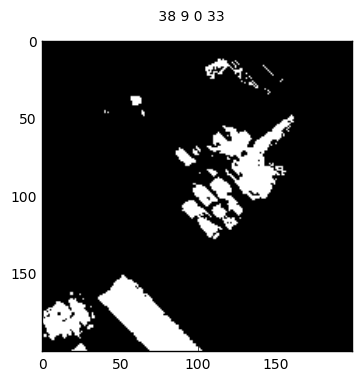

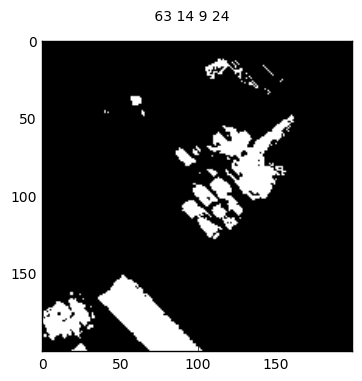

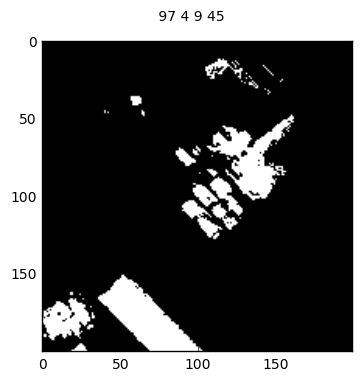

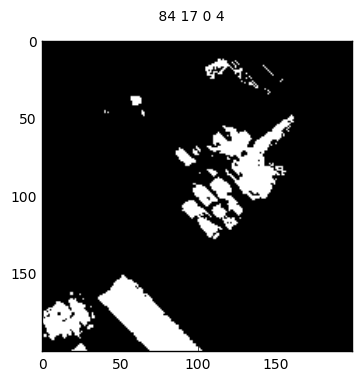

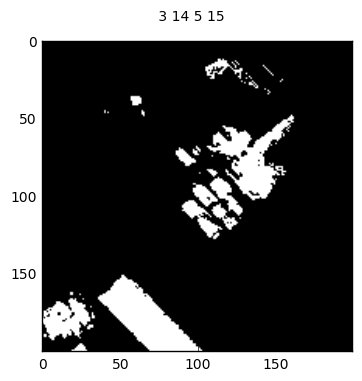

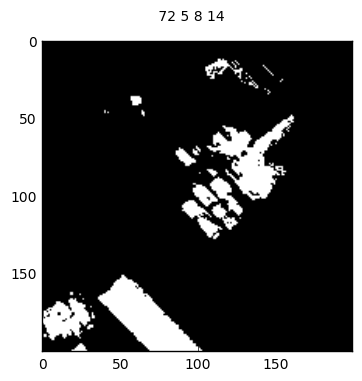

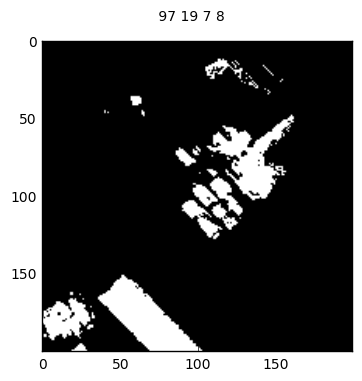

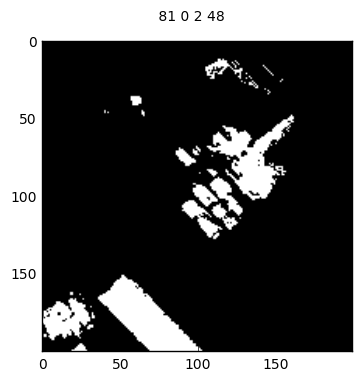

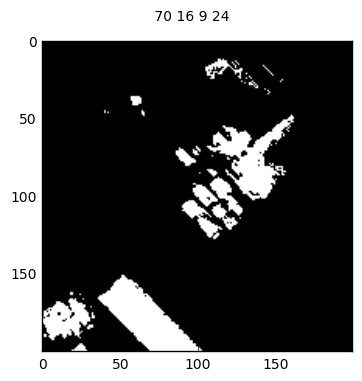

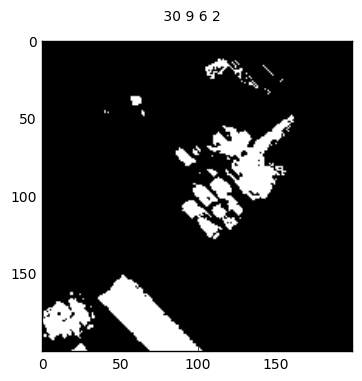

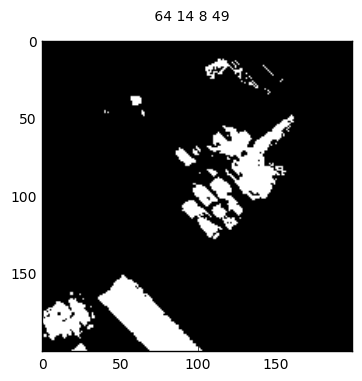

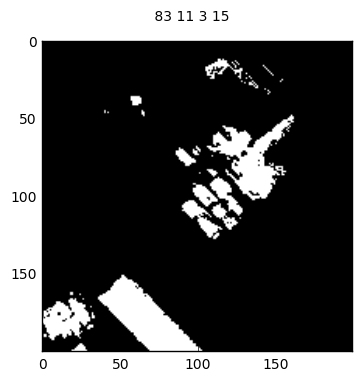

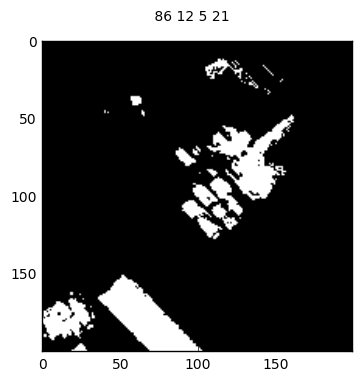

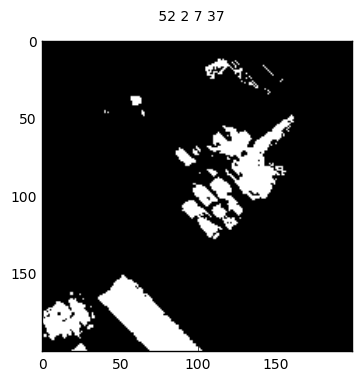

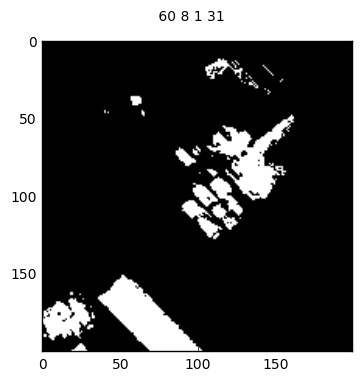

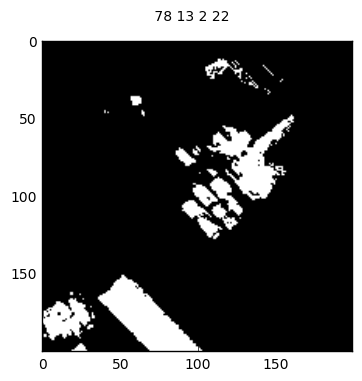

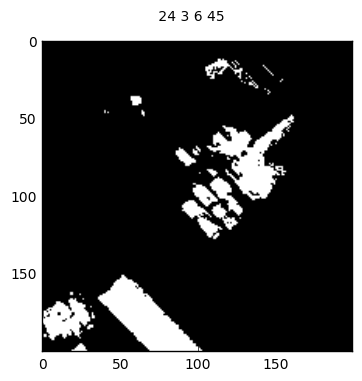

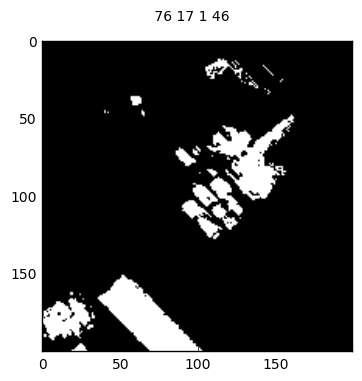

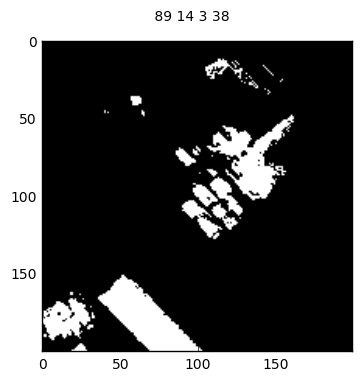

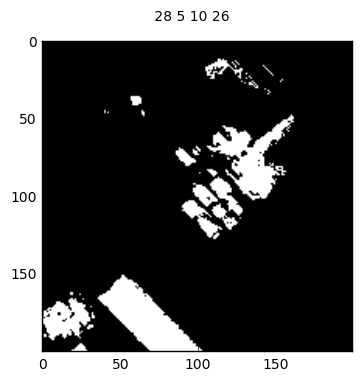

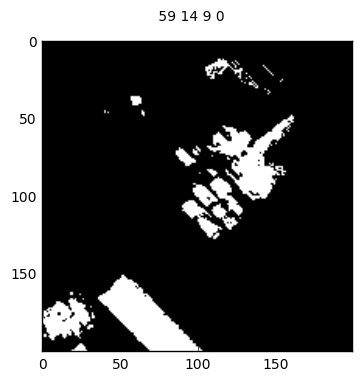

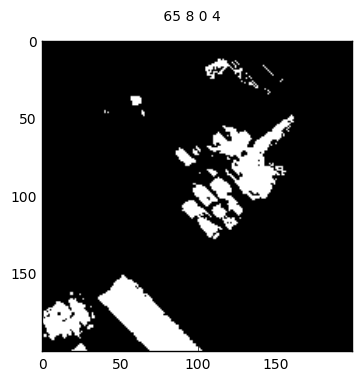

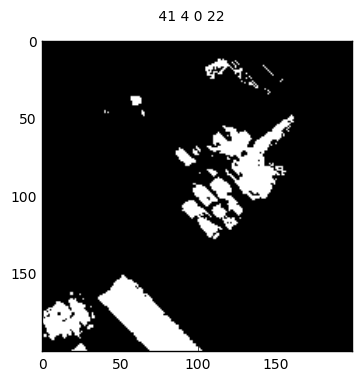

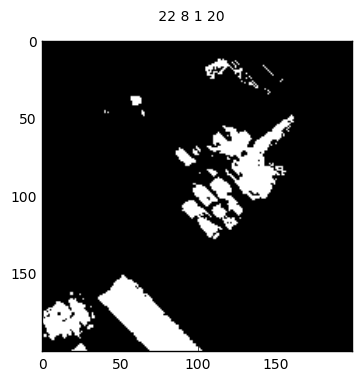

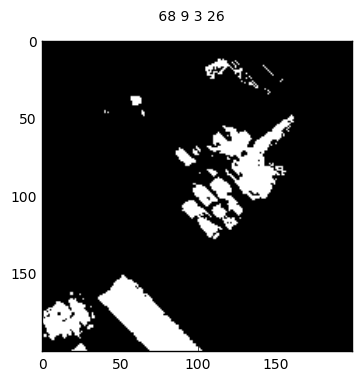

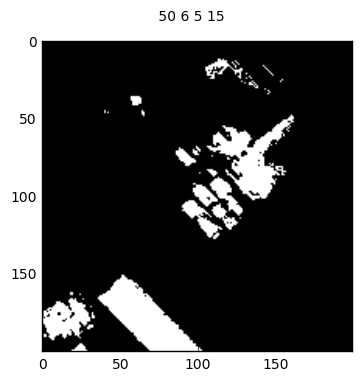

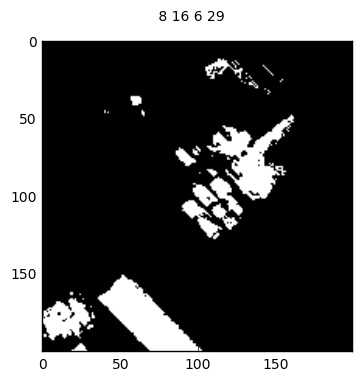

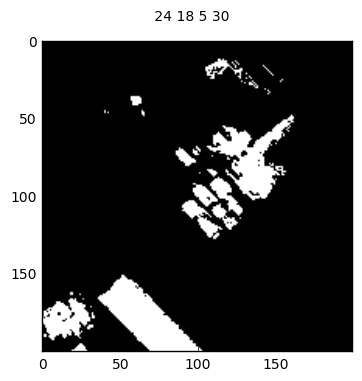

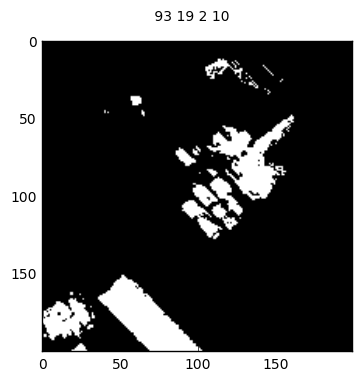

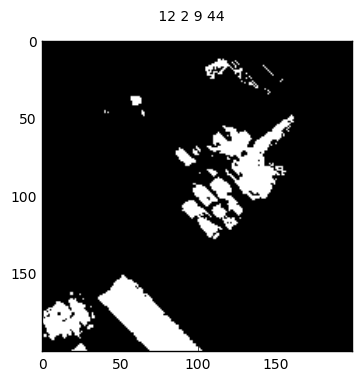

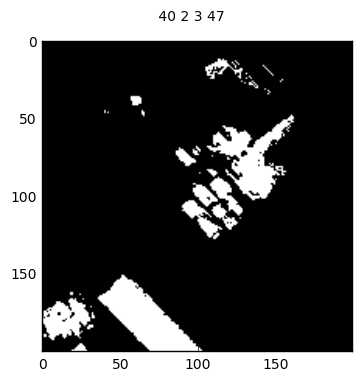

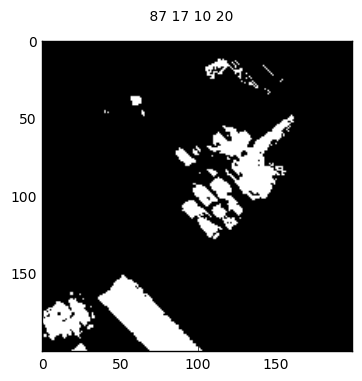

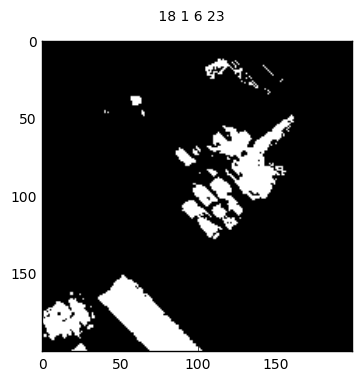

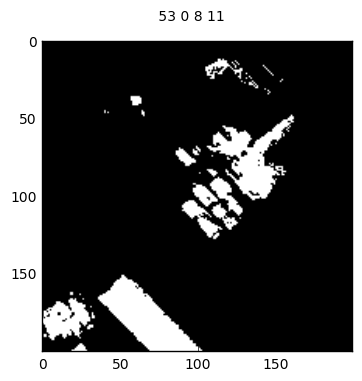

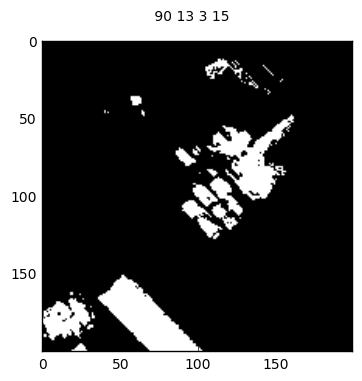

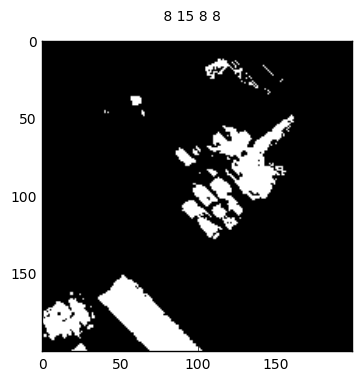

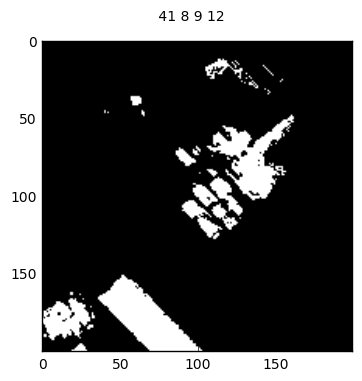

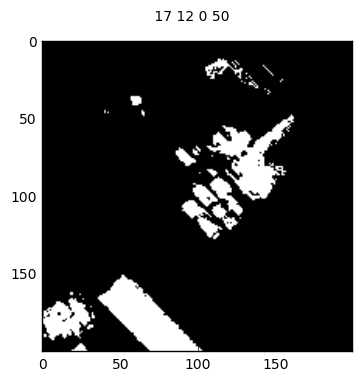

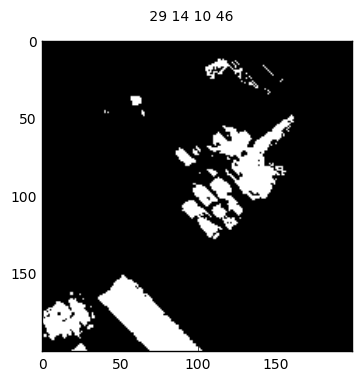

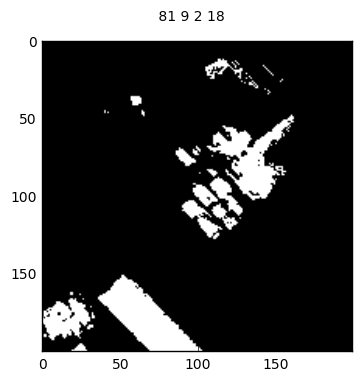

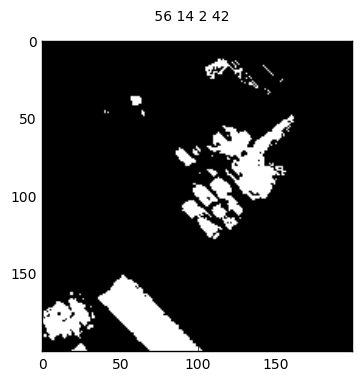

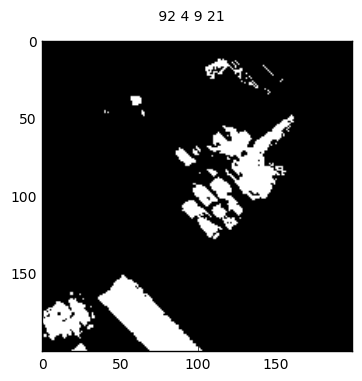

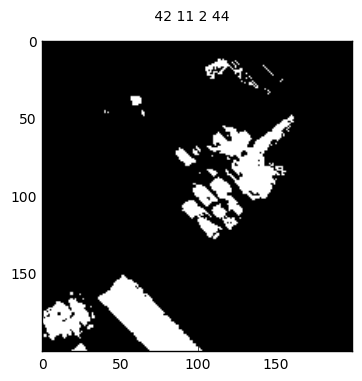

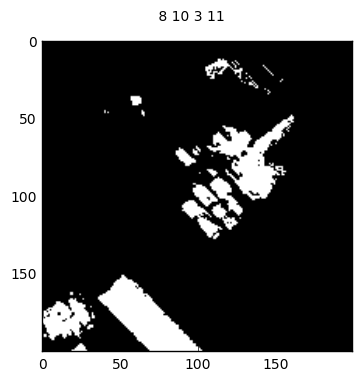

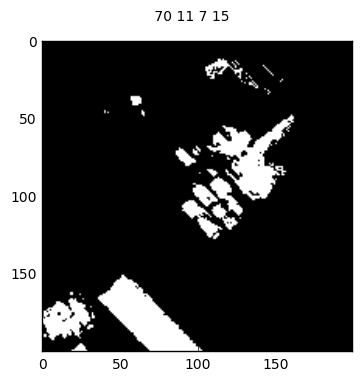

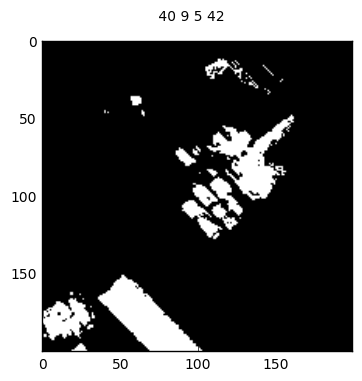

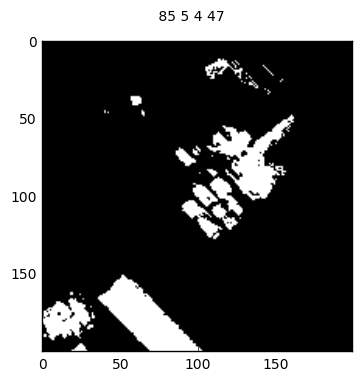

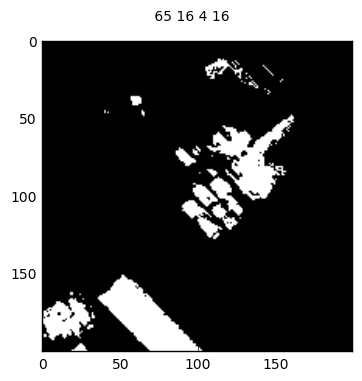

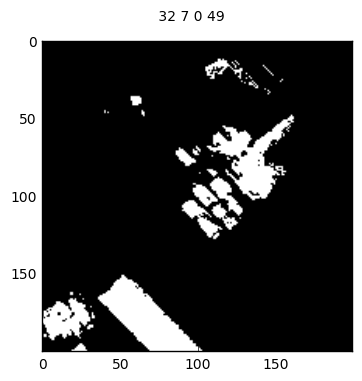

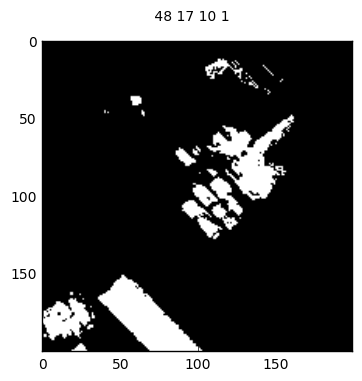

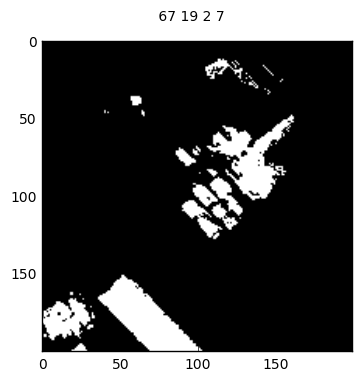

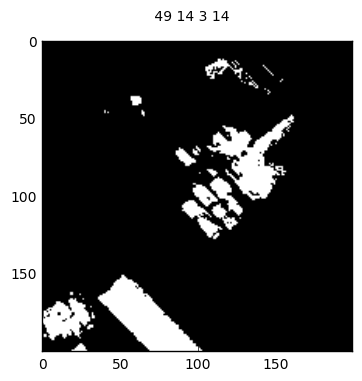

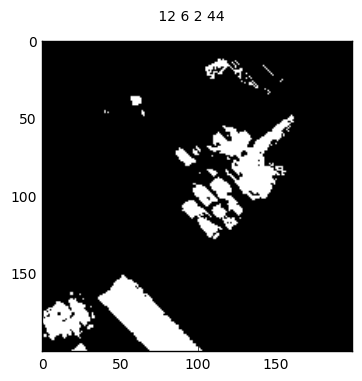

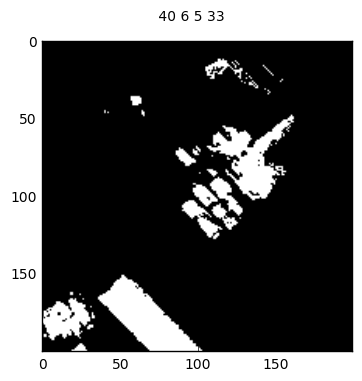

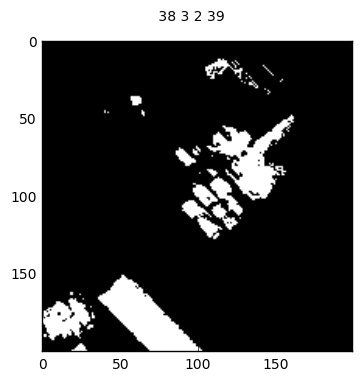

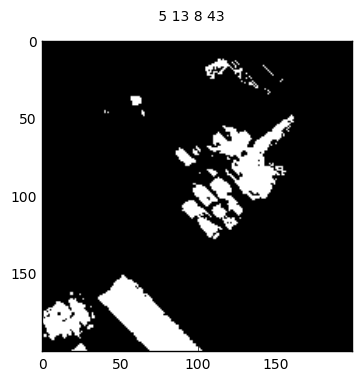

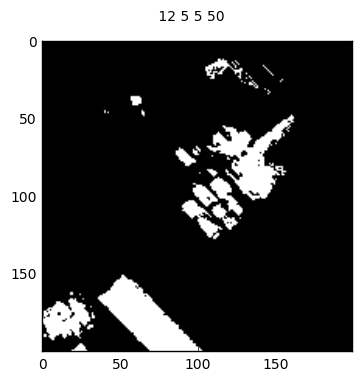

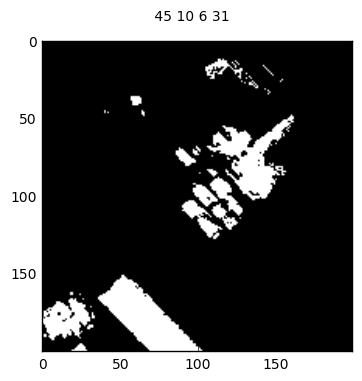

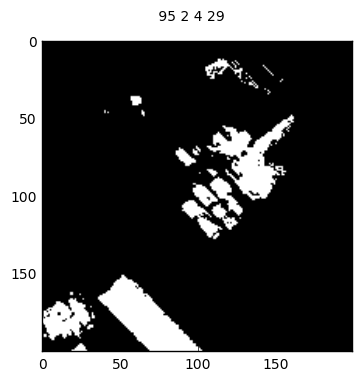

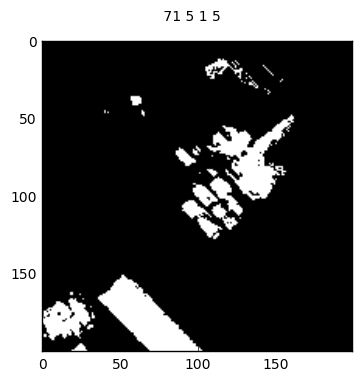

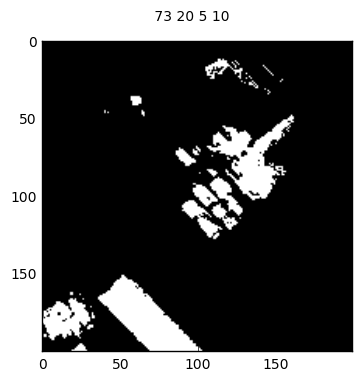

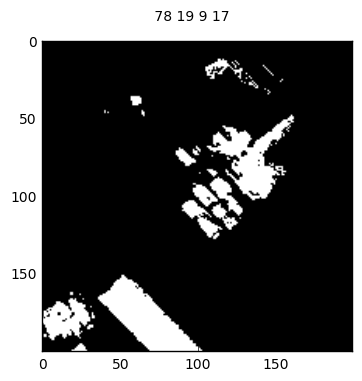

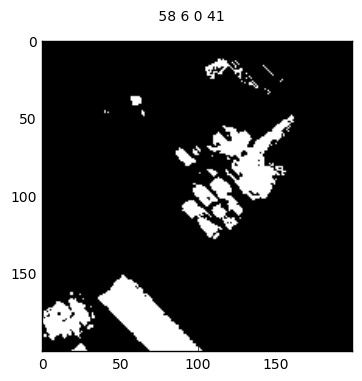

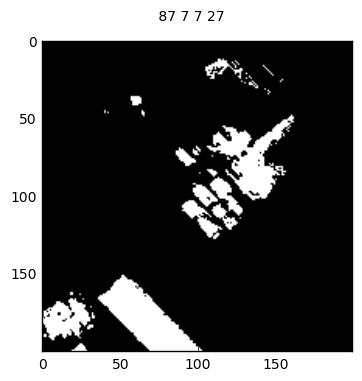

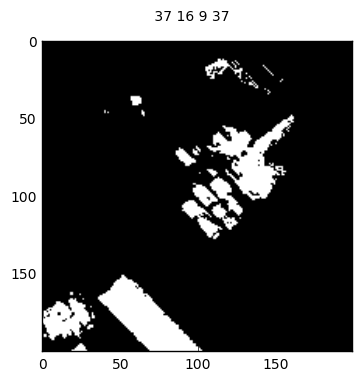

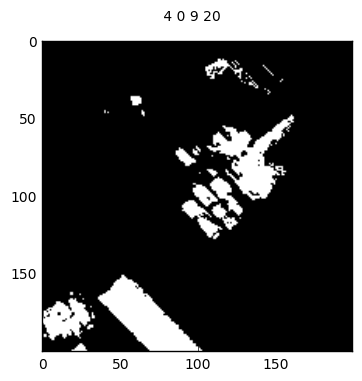

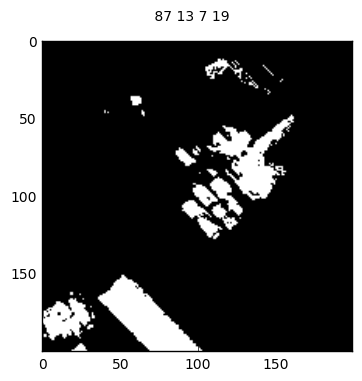

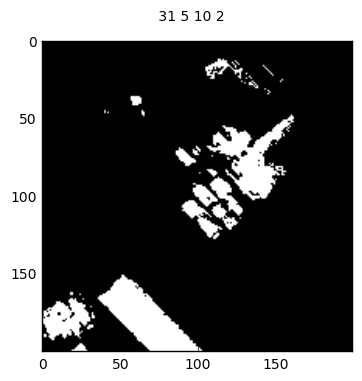

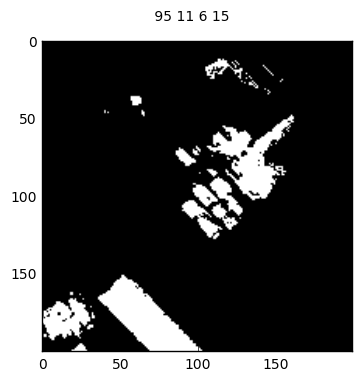

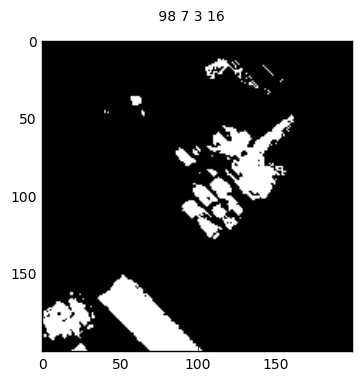

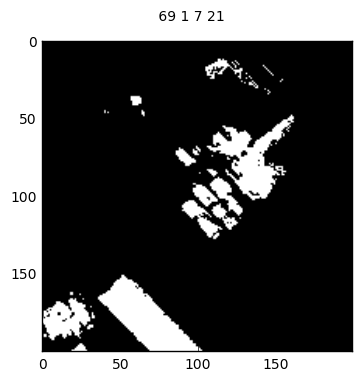

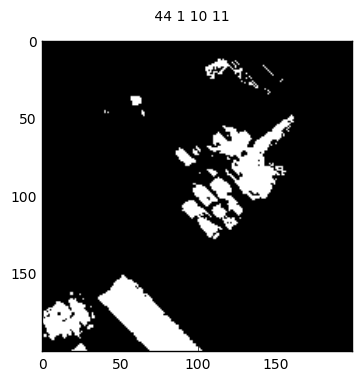

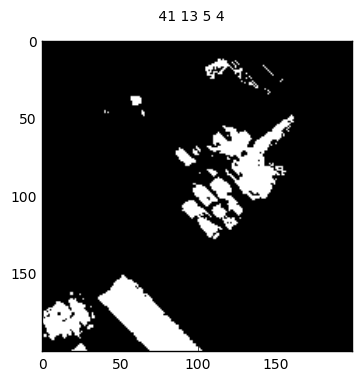

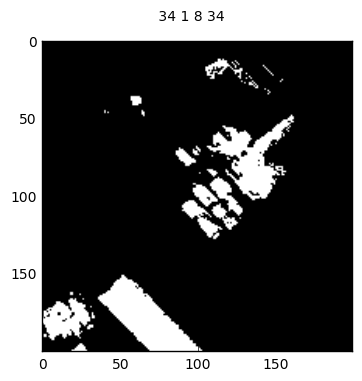

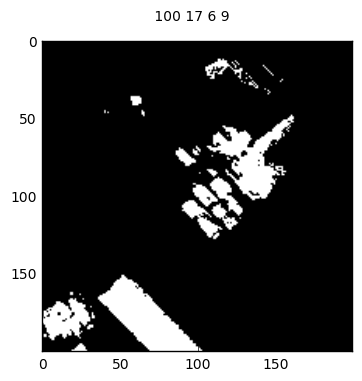

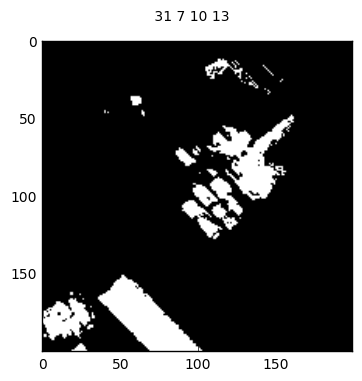

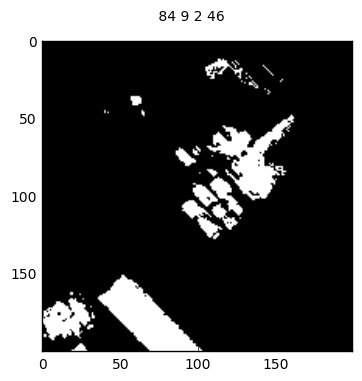

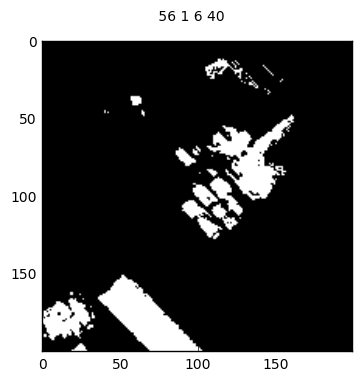

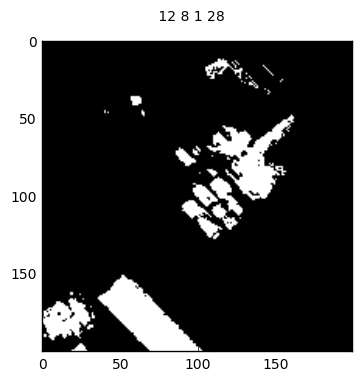

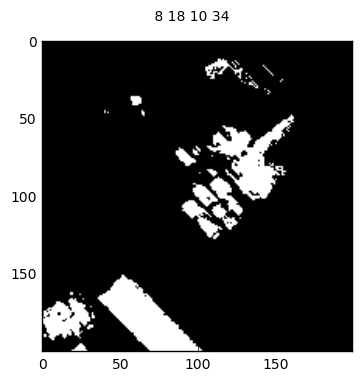

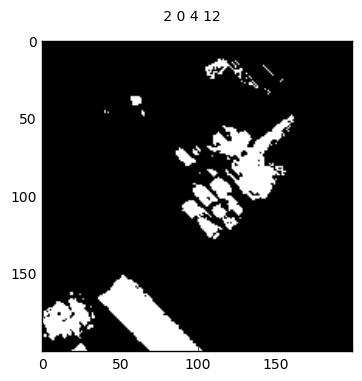

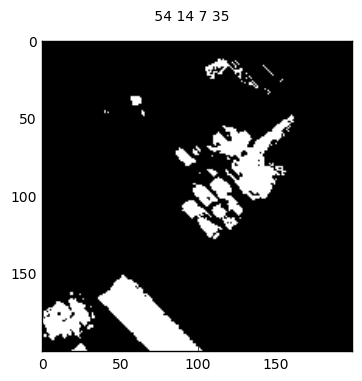

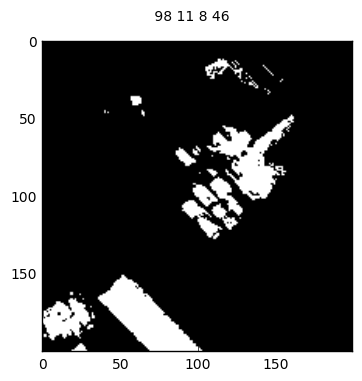

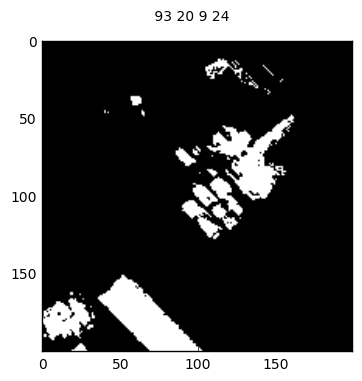

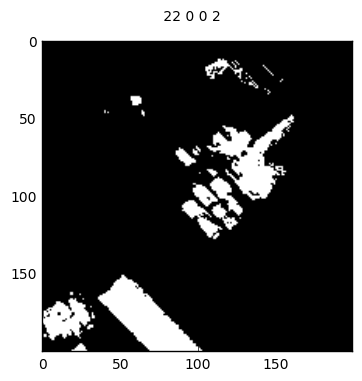

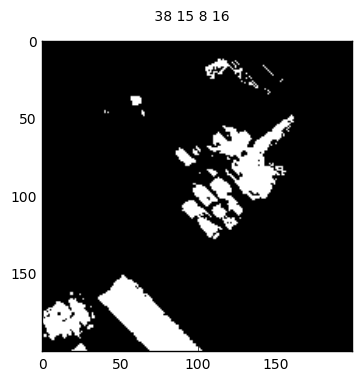

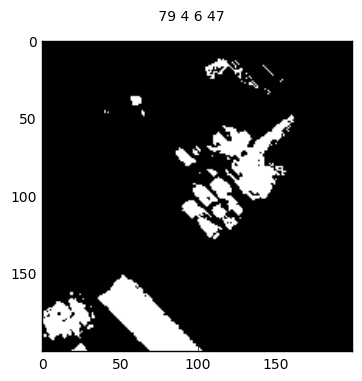

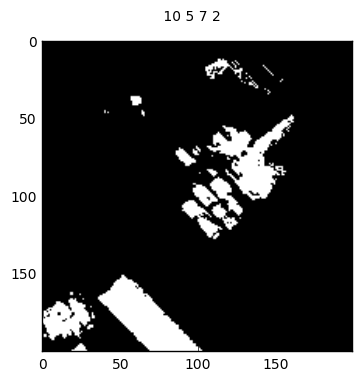

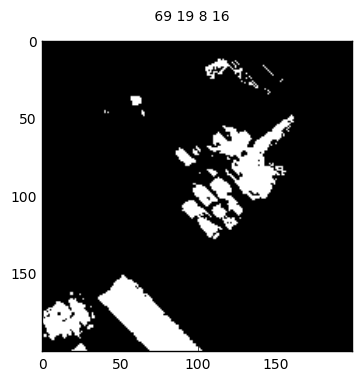

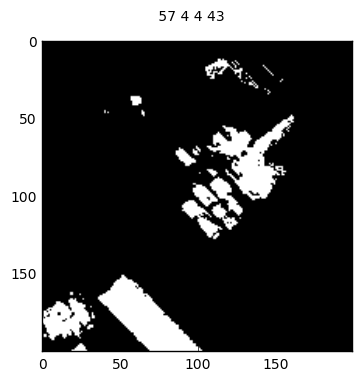

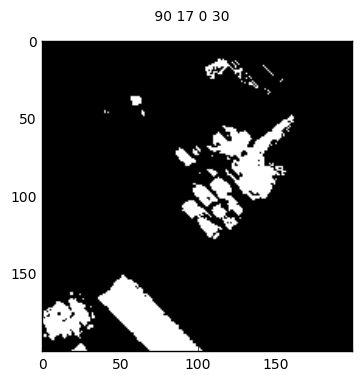

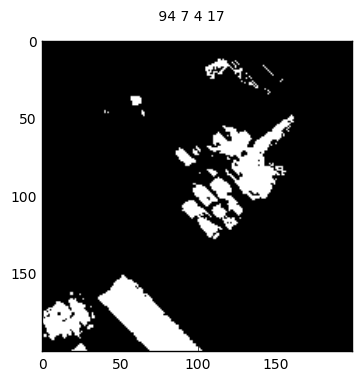

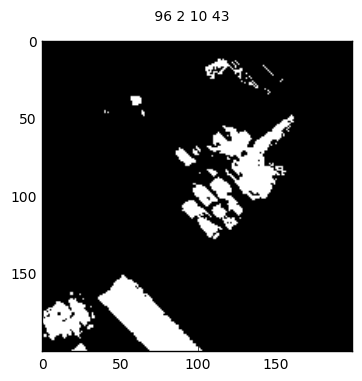

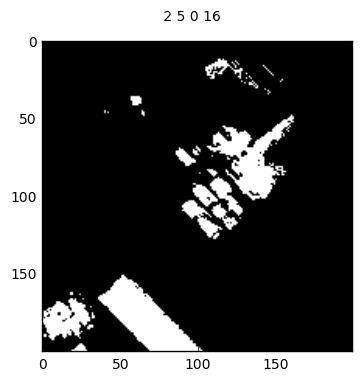

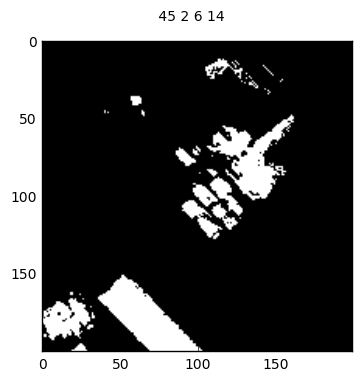

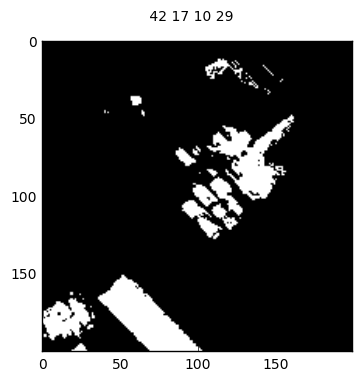

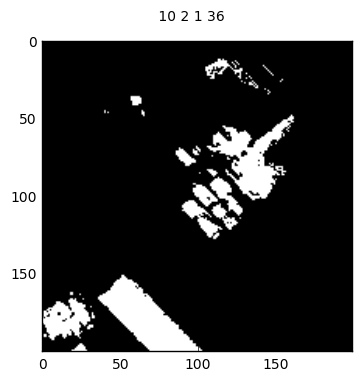

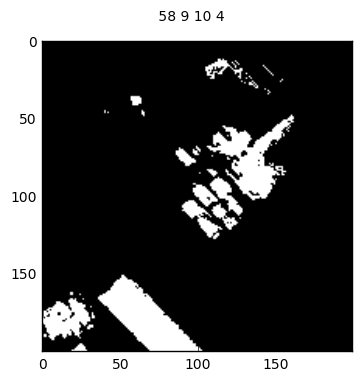

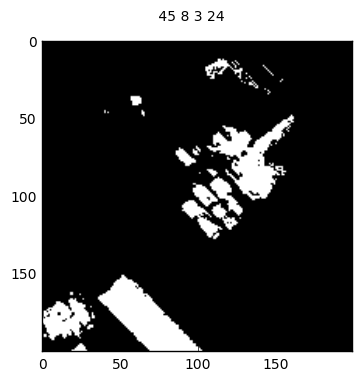

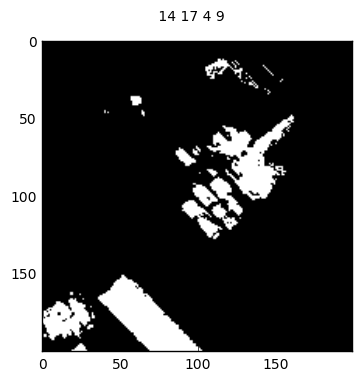

In [55]:
for i in xrange(100):
    unary=np.copy(total_unary)
    n_label = unary.shape[0]
    im_height = unary.shape[1]
    im_width = unary.shape[2]
    print n_label,im_height,im_width
    d = dcrf.DenseCRF2D(im_height, im_width, n_label)
    U = unary.reshape((n_label,-1))
    Up = (U+0.001) / (np.sum(U, axis=0))
    print np.max(Up),np.min(Up),Up.shape
    # tt=-np.log(Up+0.0000001)
    # print np.max(tt),np.min(tt)
    unary = softmax_to_unary(Up)
    d.setUnaryEnergy(unary)
    #d.addPairwiseGaussian(3, 1)
    from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
    sdims_=random.randint(0,100)
    schan_=random.randint(0,20)
    compat_=random.randint(0,10)
    pairwise_energy = create_pairwise_bilateral(sdims=(40,40), schan=(10,), img=test1_im.reshape((500,500,1)), chdim=2)
    d.addPairwiseEnergy(pairwise_energy,compat=8)
    epoch_=random.randint(0,50)
    Q = d.inference(10)
    Q = np.array(Q).reshape((n_label, im_height,im_width))
    out_label = np.argmax(Q, axis=0)
    Q.shape
    out_label.shape
    out_label_out=out_label[:200,:200]
    ss=" "+str(sdims_)+" "+str(schan_)+" "+str(compat_)+" "+str(epoch_)
    plt.figure()
    plt.suptitle(ss)
    plt.imshow(1-out_label_out,cmap=plt.get_cmap('gray'))
    #plt.figure()
    #plt.imshow(test1_hm,cmap=plt.get_cmap('gray'))
    print np.min(out_label),np.max(out_label),out_label.dtype

In [18]:
plt.imshow()

TypeError: imshow() takes at least 1 argument (0 given)

In [ ]:
print np.min(unary),np.max(unary),unary.shape

In [ ]:
d2 = dcrf.DenseCRF2D(500, 500,1) 

In [ ]:
#create_pairwise_bilateral?

In [ ]:
#pairwise_energy = create_pairwise_bilateral(sdims=(10,10), schan=(0.01,), img=test1_im.reshape((500,500,1)), chdim=2)

In [ ]:
unary = unary_from_softmax(unary)
print np.min(unary),np.max(unary),unary.shape
#unary = np.ascontiguousarray(unary)
d2.setUnaryEnergy(unary)

In [ ]:
d2.addPairwiseGaussian(sxy=3, compat=3)
#d2.addPairwiseEnergy(pairwise_energy,compat=10)

In [ ]:
Q=d2.inference(5)

In [ ]:
proba=np.array(Q)

In [ ]:
plt.imshow(proba.reshape(500,500))

In [ ]:
np.max(proba)

In [ ]:
np.min(proba)

In [ ]:
res = np.argmax(Q, axis=0).reshape((500,500))

In [ ]:
plt.imshow(res)

In [ ]:
print np.min(res),np.max(res)

In [ ]:
Q